### load data

In [82]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import calendar

In [83]:
test = pd.read_csv('bike_demand.csv')
train = pd.read_csv('bike_demand.csv')

In [84]:
full = pd.concat([train,test])

In [85]:
full = full.reset_index().drop('index', axis=1)

### feature engineering

In [86]:
full['datetime'] = pd.to_datetime(full['datetime'])
full['date'] = full['datetime'].apply(lambda x: x.date())
full['hour'] = full['datetime'].apply(lambda x: x.hour)
full['weekday'] = full['datetime'].apply(lambda x: x.weekday())
full['month'] = full['datetime'].apply(lambda x: x.month)
full['year'] = full['datetime'].apply(lambda x: x.year)

In [87]:
full.shape

(21772, 17)

### fill windspeed with 0 values

In [88]:
from sklearn.ensemble import RandomForestRegressor

In [89]:
regressor = RandomForestRegressor()

In [90]:
wind_0 = full[full['windspeed']==0]
wind_not_0 = full[full['windspeed']!=0]

In [91]:
columns_for_predictions = ['season', 'weather', 'humidity', 'month', 'temp','year', 'atemp']

In [92]:
regressor.fit(wind_not_0[columns_for_predictions], wind_not_0['windspeed'])

RandomForestRegressor()

In [93]:
windprediction = regressor.predict(wind_0[columns_for_predictions])

In [94]:
wind_0['windspeed']=windprediction

/var/folders/6h/5k5kd9fs35d2zrg3xjk3d2g80000gn/T/ipykernel_62374/3331354625.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wind_0['windspeed']=windprediction


In [95]:
full = pd.concat([wind_0, wind_not_0]).reset_index().drop('index', axis=1)

In [96]:
full.shape

(21772, 17)

In [98]:
full.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,hour,weekday,month,year
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,11.091582,3,13,16,2011-01-01,0,5,1,2011
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,9.714464,8,32,40,2011-01-01,1,5,1,2011
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,9.714464,5,27,32,2011-01-01,2,5,1,2011
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,6.605175,3,10,13,2011-01-01,3,5,1,2011
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,6.605175,0,1,1,2011-01-01,4,5,1,2011


### one-hot encoding

In [100]:
categorical = ['season', 'holiday', 'workingday','weather', 'weekday', 'month', 'year', 'hour']
Numerical = ['temp', 'humidity', 'windspeed', 'atemp']

In [101]:
for variable in categorical:
    full[variable] = full[variable].astype('category')

In [105]:
full = full.sort_values(by='datetime').drop(['datetime', 'date'], axis=1)

In [108]:
full.head(5)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,weekday,month,year
0,1,0,0,1,9.84,14.395,81,11.091582,3,13,16,0,5,1,2011
1313,1,0,0,1,9.84,14.395,81,11.091582,3,13,16,0,5,1,2011
1,1,0,0,1,9.02,13.635,80,9.714464,8,32,40,1,5,1,2011
1314,1,0,0,1,9.02,13.635,80,9.714464,8,32,40,1,5,1,2011
2,1,0,0,1,9.02,13.635,80,9.714464,5,27,32,2,5,1,2011


In [110]:
data = pd.get_dummies(full)

In [114]:
data.head(5)

,temp,atemp,humidity,windspeed,casual,registered,count,season_1,season_2,season_3,...,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_2011,year_2012
0,9.84,14.395,81,11.091582,3,13,16,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1313,9.84,14.395,81,11.091582,3,13,16,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,9.02,13.635,80,9.714464,8,32,40,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1314,9.02,13.635,80,9.714464,8,32,40,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,9.02,13.635,80,9.714464,5,27,32,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [111]:
data.shape

(21772, 64)

### train_test_split

In [112]:
from sklearn.model_selection import train_test_split

In [115]:
X = data.drop('count', axis=1).copy()
y = data['count']

In [149]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, random_state=101, test_size=0.3)

### build a prediction model

In [233]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score

In [234]:
lr = LinearRegression()

In [235]:
lr.fit(Xtrain, ytrain)

LinearRegression()

In [236]:
predict = lr.predict(Xtest)

In [237]:
np.sqrt(mean_squared_error(ytest, predict))

8.307743758388551e-14

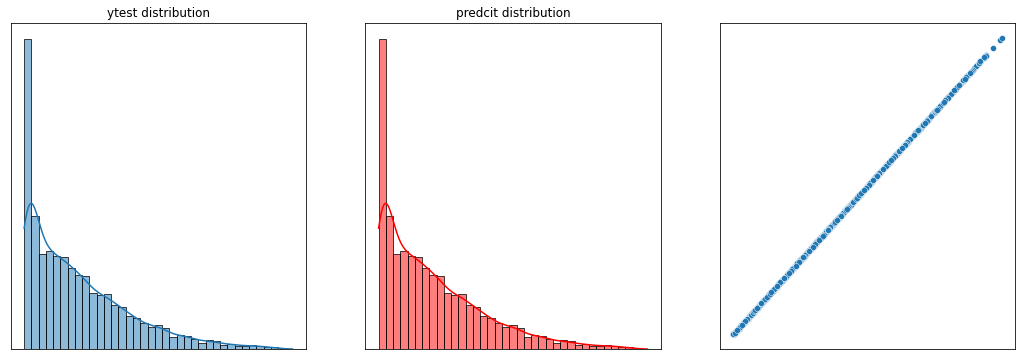

In [246]:
fig, axes = plt.subplots(1,3, figsize=(18,6), subplot_kw=dict(xticks=[],yticks=[]))
sns.histplot(ytest, kde=True, ax=axes[0])
axes[0].set_title('ytest distribution')
sns.histplot(pred, kde=True, ax=axes[1], color='r')
axes[1].set_title('predcit distribution')
sns.scatterplot(x=ytest, y=predict, ax=axes[2]);

### build a lasso model

In [247]:
lasso = Lasso()

In [248]:
lasso.fit(Xtrain, ytrain)

Lasso()

In [249]:
pred = lasso.predict(Xtest)

In [250]:
np.sqrt(mean_squared_error(ytest, pred))

0.02138868981328108

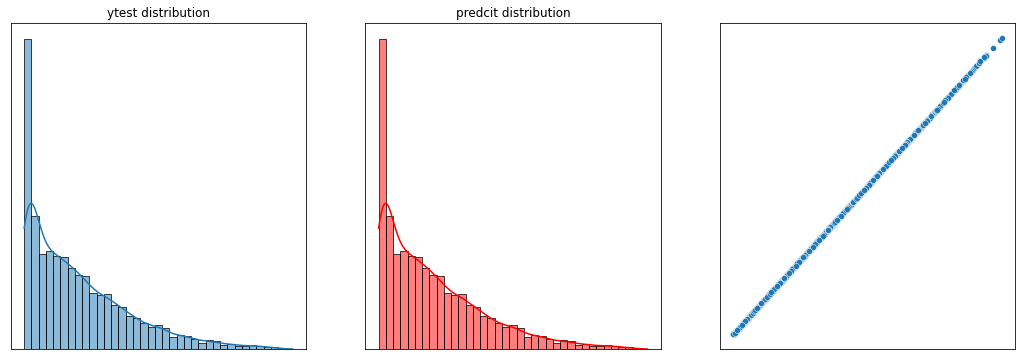

In [252]:
fig, axes = plt.subplots(1,3, figsize=(18,6), subplot_kw=dict(xticks=[],yticks=[]))
sns.histplot(ytest, kde=True, ax=axes[0])
axes[0].set_title('ytest distribution')
sns.histplot(pred, kde=True, ax=axes[1], color='r')
axes[1].set_title('predcit distribution')
sns.scatterplot(x=ytest, y=pred, ax=axes[2]);

### build a ridge model

In [253]:
ridge = Ridge()

In [254]:
ridge.fit(Xtrain, ytrain)

Ridge()

In [255]:
preds = ridge.predict(Xtest)

In [257]:
np.sqrt(mean_squared_error(preds, ytest))

2.118523558131704e-06

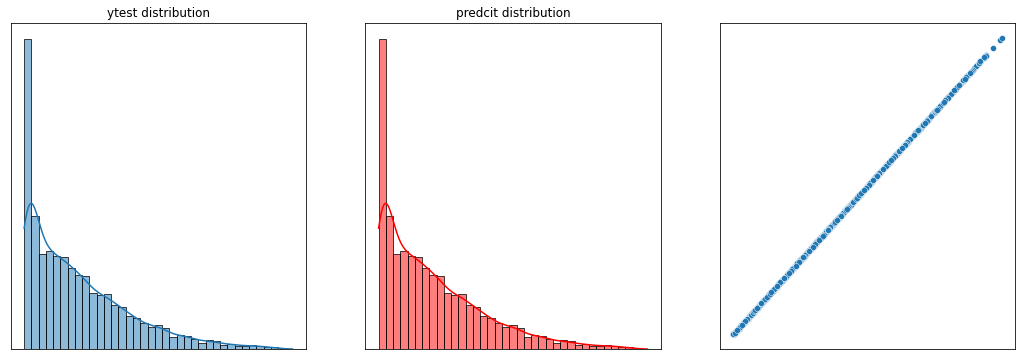

In [258]:
fig, axes = plt.subplots(1,3, figsize=(18,6), subplot_kw=dict(xticks=[],yticks=[]))
sns.histplot(ytest, kde=True, ax=axes[0])
axes[0].set_title('ytest distribution')
sns.histplot(pred, kde=True, ax=axes[1], color='r')
axes[1].set_title('predcit distribution')
sns.scatterplot(x=ytest, y=preds, ax=axes[2]);

### build Random forest regression model

In [195]:
rf = RandomForestRegressor()

In [196]:
rf.fit(Xtrain, ytrain)

RandomForestRegressor()

In [197]:
prediction = rf.predict(Xtest)

In [261]:
np.sqrt(mean_squared_error(ytest, prediction))

1.9284615293486116

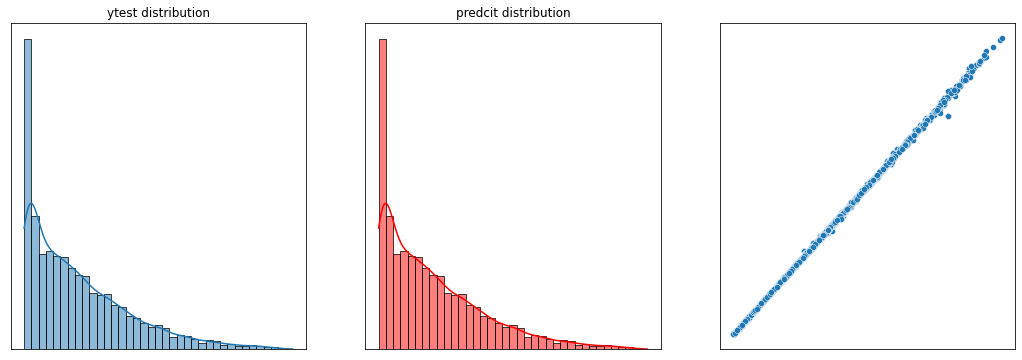

In [263]:
fig, axes = plt.subplots(1,3, figsize=(18,6), subplot_kw=dict(xticks=[],yticks=[]))
sns.histplot(ytest, kde=True, ax=axes[0])
axes[0].set_title('ytest distribution')
sns.histplot(pred, kde=True, ax=axes[1], color='r')
axes[1].set_title('predcit distribution')
sns.scatterplot(x=ytest, y=prediction, ax=axes[2]);